## 1. Подготовка данных

In [6]:
# Импортируем библиотеки 
import pandas as pd
import requests
from urllib.parse import urlencode
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
#Создаем списки для загрузки таблиц через цикл
urls = ['BevOtP8g_Q4IhQ', 'J0us59vYxsWjaQ', 'k9JONmurr-lNLQ', '4zFeSBhbSpVdbQ']
data_names = ['test', 'courses', 'assessment', 'registration']

In [9]:
# Скачиваем файлы с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
for i in range(len(urls)):
    public_key = 'https://disk.yandex.ru/d/' + urls[i]
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его в датафрейм с заданным именем
    download = requests.get(download_url).content
    locals()[data_names[i]] = pd.read_csv(io.StringIO(download.decode('utf-8')))

## 2. Разведочный анализ (EDA)

1. Объединяем таблицы с информацией о тестах и результатами тестов
2. Смотрим на дубликаты, пропущенные значения

In [10]:
exam_results = assessment.merge(test, on = 'id_assessment').query("assessment_type == 'Exam'") 
exam_results.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


In [11]:
exam_results.loc[exam_results.duplicated(['code_module','id_student'])]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
87566,25361,527323,234,0,18.0,DDD,2014B,Exam,241.0,100.0
87573,25361,540758,234,0,60.0,DDD,2014B,Exam,241.0,100.0
95711,25368,593903,243,0,44.0,DDD,2014J,Exam,NaN,100.0
95749,25368,605118,243,0,64.0,DDD,2014J,Exam,NaN,100.0


In [12]:
exam_results.isna().sum()

id_assessment           0
id_student              0
date_submitted          0
is_banked               0
score                   0
code_module             0
code_presentation       0
assessment_type         0
date                 2865
weight                  0
dtype: int64

Посмотрим на аномалии таблицы с информацией о регистрации и заполним пропущенные значения в столбце date_registration, чтобы избежать дальнейших ошибок при расчетах

In [13]:
registration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [14]:
registration[registration.date_registration.isna() == True].head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0


In [15]:
registration['date_registration'] = registration['date_registration'].fillna(0)

## 3. Анализ аудитории и особенности прохождения курсов

#### АНАЛИЗ ЗАВЕРШАЕМОСТИ ЭКЗАМЕНОВ

Несколько студентов сдавали экзамен по одному и тому же предмету, но в разных семестрах. Учитываем их как дубликаты при рассчете среднего срока сдачи экзамена и количества студентов, сдавших только 1 курс.

1. Выведем строки с дубликатами по названию предмета и id студента  

In [16]:
duplicates = list(exam_results.loc[exam_results.duplicated(['code_module','id_student'])]['id_student'])
exam_results.query('id_student == @duplicates').sort_values('id_student')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
69928,25340,527323,229,0,24.0,DDD,2013B,Exam,240.0,100.0
87566,25361,527323,234,0,18.0,DDD,2014B,Exam,241.0,100.0
69983,25340,540758,229,0,40.0,DDD,2013B,Exam,240.0,100.0
87573,25361,540758,234,0,60.0,DDD,2014B,Exam,241.0,100.0
82731,25354,593903,241,0,49.0,DDD,2013J,Exam,261.0,100.0
95711,25368,593903,243,0,44.0,DDD,2014J,Exam,NaN,100.0
82844,25354,605118,237,0,42.0,DDD,2013J,Exam,261.0,100.0
95749,25368,605118,243,0,64.0,DDD,2014J,Exam,NaN,100.0


1. Группируем экзамены по курсам и id
2. Считаем количество всех попыток сдать экзамен и количество успешных сдач
3. Считаем процент успешной сдачи экзамена

In [17]:
exam_attempts = exam_results.assign(success = exam_results.score >= 40) \
            .groupby(['code_module', 'code_presentation']) \
            .agg({'id_assessment': 'count', 'success': 'sum'}) \
            .rename(columns = {'id_assessment': 'all_attempts'}) 
exam_attempts = exam_attempts.assign(success_percentage = round(exam_attempts.success / exam_attempts.all_attempts * 100, 2))
exam_attempts

all_attempts  success  success_percentage
code_module code_presentation                                           
CCC         2014B                       747      664               88.89
            2014J                      1168     1019               87.24
DDD         2013B                       602      504               83.72
            2013J                       968      878               90.70
            2014B                       524      485               92.56
            2014J                       950      842               88.63

In [18]:
print(f"Самый сложный экзамен по предмету {exam_attempts[exam_attempts.success_percentage == exam_attempts.success_percentage.min()].index[0][0]} в семестре {exam_attempts[exam_attempts.success_percentage == exam_attempts.success_percentage.min()].index[0][1]}")
print(f"Самый легкий экзамен по предмету {exam_attempts[exam_attempts.success_percentage == exam_attempts.success_percentage.max()].index[0][0]} в семестре {exam_attempts[exam_attempts.success_percentage == exam_attempts.success_percentage.max()].index[0][1]}")

Самый сложный экзамен по предмету DDD в семестре 2013B
Самый легкий экзамен по предмету DDD в семестре 2014B


#### АНАЛИЗ РЕГИСТРАЦИИ НА КУРСЫ

1. Создаем колонку, по которой будем определять группу по регистрации на курс. Учитываем людей, которые регистрировались на курс более одного раза. 
2. По коэффициенту в колонке unregistred (отношение отмененных регистраций к общему количеству регистраций) можно разбить пользователей на несколько групп
 

In [19]:
registration['unregistred'] = registration.date_unregistration.isna() == 0

unregistration = registration.groupby(['id_student', 'code_module'], as_index = False) \
                .agg({'date_registration': 'count', 'unregistred': 'mean'}).round(1)
unregistration.head()

,id_student,code_module,date_registration,unregistred
0,3733,DDD,1,1.0
1,6516,AAA,1,0.0
2,8462,DDD,2,1.0
3,11391,AAA,1,0.0
4,23629,BBB,1,0.0


Уникальные значения в колонке unregistred

In [20]:
unregistration.unregistred.unique()

array([1. , 0. , 0.5, 0.7, 0.3])


Интерпретация значения Unregistred:   
0 - отмены регистрации не было    
1 - отмена регистации, человек не вернулся  
0.3 - отмена регистрации 1 раз из 3-х (человек закончил один и тот же курс 2 раза)  
0.5 - отмена регистрации один раз, человек поступил на курс еще раз  
0.7 - отмена регистрации два раза, человек поступил на курс в третий раз 

In [21]:
print(f'Отменяли регистрацию без последующего возвращения на курс {unregistration[unregistration.unregistred == 1].id_student.count()} раз')
print(f'Отменяли регистрацию 1 раз и перепоступали на курс {unregistration[unregistration.unregistred == 0.5].id_student.count()} раз')
print(f'Отменяли регистрацию 2 раза и перепоступали на курс в третий раз {unregistration[unregistration.unregistred == 0.7].id_student.count()} раз')

Отменяли регистрацию без последующего возвращения на курс 8847 раз
Отменяли регистрацию 1 раз и перепоступали на курс 717 раз
Отменяли регистрацию 2 раза и перепоступали на курс в третий раз 17 раз


Cчитаем количество уникальных id студентов, зарегистрировавшихся на курс 

In [22]:
registration_groups = registration.sort_values('unregistred') \
            .drop_duplicates(['id_student', 'code_module'], keep = 'first') \
            .groupby(['code_module']) \
            .agg({ 'id_student': 'nunique', 'unregistred': 'sum'}) \
            .rename(columns = {'id_student': 'registred'})
registration_groups.sort_values('unregistred', ascending = False)

,registred,unregistred
code_module,,
BBB,7692,2180
FFF,7397,2041
DDD,5848,1839
CCC,4251,1764
EEE,2859,650
GGG,2525,281
AAA,712,92


Считаем процент оттока по предметам

In [23]:
churn_rate = registration_groups.assign(churn_rate = round(registration_groups.unregistred / registration_groups.registred * 100, 1))
churn_rate

,registred,unregistred,churn_rate
code_module,,,
AAA,712,92,12.9
BBB,7692,2180,28.3
CCC,4251,1764,41.5
DDD,5848,1839,31.4
EEE,2859,650,22.7
FFF,7397,2041,27.6
GGG,2525,281,11.1


#### График распределения популярности курсов по регистрации

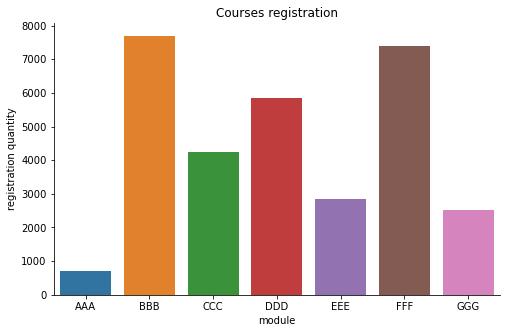

In [38]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = registration_groups.reset_index(), x = 'code_module', y = 'registred')
ax.set(ylabel = 'registration quantity', xlabel = 'module', title = 'Courses registration')
sns.despine()

#### График распределения churn rate курсов

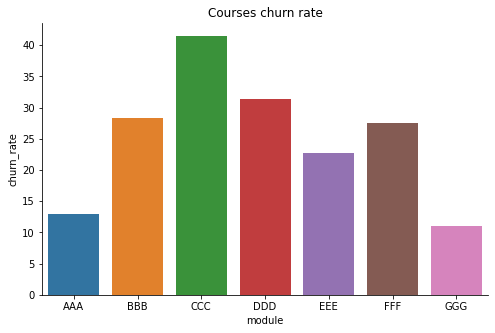

In [39]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = churn_rate.reset_index(), x = 'code_module', y = 'churn_rate')
ax.set(ylabel = 'churn_rate', xlabel = 'module', title = 'Courses churn rate')
sns.despine()

#### КОГОРТНЫЙ АНАЛИЗ КУРСОВ

1. Предобрабатываем данные по экзаменам
2. Группируем по семестрам и предметам
3. Считаем среднее время сдачи экзамена студентами и коэффициент завершаемости курсов

In [26]:
exam_results['date'] = exam_results['date'].fillna(0)
exam_results = exam_results.assign(success = exam_results.score >= 40)

In [27]:
course_result = exam_results.groupby(['code_module', 'code_presentation'], as_index = False) \
                .agg({'success': 'mean', 'date_submitted': 'mean'}).round(2).sort_values('code_presentation')
course_result.date_submitted = course_result.date_submitted.astype('int')
course_result

,code_module,code_presentation,success,date_submitted
2,DDD,2013B,0.84,230
3,DDD,2013J,0.91,239
0,CCC,2014B,0.89,231
4,DDD,2014B,0.93,234
1,CCC,2014J,0.87,244
5,DDD,2014J,0.89,242


#### График изменения средней даты сдачи экзаменов по семестрам

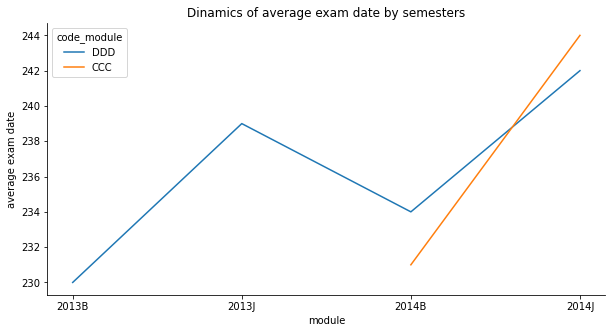

In [40]:
plt.figure(figsize = (10, 5))
ax = sns.lineplot(data = course_result, x = 'code_presentation', y = 'date_submitted', hue = 'code_module')
ax.set(ylabel = 'average exam date', xlabel = 'module', title = 'Dinamics of average exam date by semesters')
sns.despine()

#### График изменения завершаемости курсов по семестрам

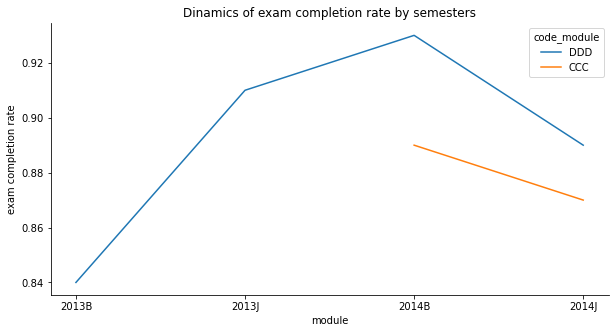

In [41]:
plt.figure(figsize = (10, 5))
ax = sns.lineplot(data = course_result, x = 'code_presentation', y = 'success', hue = 'code_module')
ax.set(ylabel = 'exam completion rate', xlabel = 'module', title = 'Dinamics of exam completion rate by semesters')
sns.despine()

#### СЕГМЕНТАЦИЯ АУДИТОРИИ (RFM анализ)

Recency - среднее время сдачи экзамена  
Frequency - завершаемость экзаменов (количество успешных попыток сдачи тестов / все попытки сдач)  
Monetary - среднее количество баллов, полученное студентом за экзамен

Проверяем, есть ли выбросы в значениях, которые мы будем использовать для анализа по recency и monetary

In [30]:
exam_results[['date_submitted', 'score']].describe()

,date_submitted,score
count,4959.000000,4959.000000
mean,238.483565,65.572898
std,5.717577,20.579186
min,229.000000,0.000000
25%,234.000000,51.000000
50%,241.000000,67.000000
75%,243.000000,82.000000
max,285.000000,100.000000


Сформируем таблицу, которая для каждого студента будет определять его сегмент по каждому параметру.  

Посмотрим на уникальные значения по параметру frequency и количество человек в каждой категории.  

In [31]:
students = exam_results.groupby('id_student').agg({'success': 'mean', 'score': 'mean', 'date_submitted': 'mean'}) \
                            .rename(columns = { 'date_submitted': 'recency' , 'success': 'frequency', 'score': 'monetary'})
students[['recency', 'monetary']] = students[['recency', 'monetary']].round()
students['frequency'] = students['frequency'].round(2)
students.head()

,frequency,monetary,recency
id_student,,,
23698,1.0,80.0,243.0
24213,1.0,58.0,236.0
27116,1.0,96.0,243.0
28046,1.0,40.0,237.0
28787,1.0,44.0,243.0


In [32]:
students.frequency.value_counts()

1.0    4069
0.0     536
0.5      28
Name: frequency, dtype: int64

In [33]:
students.frequency.describe()

count    4633.000000
mean        0.881286
std         0.321142
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: frequency, dtype: float64

Создаем датафрейм rfm с границами метрик (right - нижняя граница, left - верхняя граница)  
Разбиваем аудиторию на кластеры - по каждому показателю создадим 3 группы.  
Для параметров recency и monetary разделять на сегменты будем по значениям процентиллей, а для показателя frecuency зададим границы сегментов самостоятельно.

In [34]:
rfm = pd.DataFrame()
rfm['recency_left'] = students.recency.quantile([0, 0.5, 0.75]).round().reset_index(drop = True)
rfm['recency_right'] = students.recency.quantile([0.5, 0.75, 1]).round().reset_index(drop = True)

rfm['frequency_left'] = [0.51, 0.1, 0]
rfm['frequency_right'] = [1, 0.51, 0.1]

rfm['monetary_left'] = students.monetary.quantile([0.5, 0.25, 0]).round().reset_index(drop = True)
rfm['monetary_right'] = students.monetary.quantile([1, 0.5, 0.25]).round().reset_index(drop = True)
rfm.index = (1, 2, 3)
rfm

,recency_left,recency_right,frequency_left,frequency_right,monetary_left,monetary_right
1,229.0,241.0,0.51,1.00,66.0,100.0
2,241.0,243.0,0.10,0.51,50.0,66.0
3,243.0,285.0,0.00,0.10,0.0,50.0


Напишем функцию для определения сегмента пользователя и построим график распределения по результатам сегментации.

In [35]:
def rfm_func (recency, frequency, monetary):
    for row in rfm.itertuples():
        if row.recency_left < recency <= row.recency_right:
            r = row.Index
        elif recency == row.recency_left:
            r = row.Index
        if row.frequency_left < frequency <= row.frequency_right:
            f = row.Index
        elif frequency == row.frequency_left:
            f = row.Index
        if row.monetary_left < monetary <= row.monetary_right:
            m = row.Index
        elif monetary == row.monetary_left:
            m = row.Index
    return( int(r* 100 + f * 10 + m) ) 

In [36]:
students['rfm_segment'] = students[['recency', 'frequency', 'monetary']].apply(lambda row: rfm_func(row[0], row[1], row[2]), axis = 1)

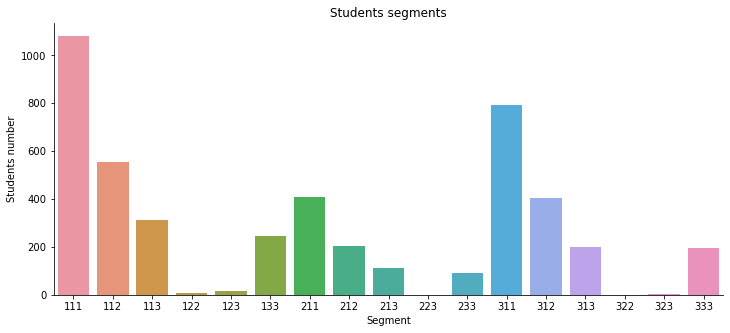

In [42]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(data = students, x = 'rfm_segment')
ax.set(ylabel = 'Students number', xlabel = 'Segment', title = 'Students segments')
sns.despine()

   ### Выводы:
1. Наиболее многочисленные сементы:  
    - 111 - пользователи, чаще сдающие экзамен до 241 дня от начала семестра, успешно завершающие его и набравшие более 66 баллов за экзамен
    - 311 - позьзователи, которые успешно завершили курс, набрали более 66 баллов, но в более поздние сроки - более 243 дней)
    - 112 - пользователи, которые успешно завершили курс, сдали экзамен в период до 241 дня и набравшие от 50 до 66 баллов  
    
    
2. В сегменты с наименьшим количеством человек попали студенты, параметры frequency и monetary для которых преимущетсвенно в 2 и 3 группах (с небольшим количеством набранных за экзамен баллов и менее, чем 50 % процентом завершенных курсов)

В целевой сегмент, в котором студенты успешно проходят курсы в более короткие сроки, попало наибольшее количество человек. 
Для увеличения численности целевого сегмента можно при наличии оценить индивидуальные параметры пользователей и подумать, какие факторы могут влиять на низкую завершаемость курсов, меньшее количество баллов за экзамен и более долгие сроки сдачи.